### Notebook to analyse *.nc files (with single variables) 

In [1]:
#TODO: extend to multiple variables 

# Imports
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import iris
from iris.analysis import Aggregator
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation
from iris.util import rolling_window
from ruamel import yaml
from tqdm import tqdm
from ruamel.yaml import ruamel
import warnings

Utilizing 
https://scitools.org.uk/iris/docs/latest/examples/General/custom_aggregation.html

#### Some initial data probing

In [2]:
# test for multi model execution


data = '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output/data_mpi-esm1-2-hr.yml'

print(data)

with open(data, 'r') as stream:
        try:
            filepaths = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
print(filepaths)

/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output/data_mpi-esm1-2-hr.yml
['/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20612070.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20512060.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20312040.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20152020.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20212030.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20712080.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20912100.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20812090.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp

#### Some statistics

In [5]:
# load data
# function to filter for specific variables

def filter_cube (cube,variablename):
    return cube.extract(variablename)
   
variablename = "approx_fresh_daily_snow_height"
cubelist = iris.load(filepaths,variablename)
print(cubelist)
constrained_cubes = iris.cube.CubeList()
# restrict on latitudes above northern tropic
northernTropic = iris.Constraint(latitude=lambda v: 23 <= v)

for i_cube in tqdm(cubelist):
    constrained_cubes.append(i_cube.extract(northernTropic))
    
print (constrained_cubes)   

100%|██████████| 9/9 [00:00<00:00, 145.23it/s]

0: approx_fresh_daily_snow_height / (1) (time: 2192; latitude: 360; longitude: 720)
1: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
2: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 360; longitude: 720)
3: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
4: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 360; longitude: 720)
5: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
6: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 360; longitude: 720)
7: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
8: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
0: approx_fresh_daily_snow_height / (1) (time: 2192; latitude: 134; longitude: 720)
1: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)
2: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitud

In [6]:
analyisis_cubes = constrained_cubes
# always use analysis cubes, input can be changed here and only here
 # add some auxilary coordinates
for i_cube in tqdm(analyisis_cubes):
  iris.coord_categorisation.add_year(i_cube, 'time', name='year')

100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


In [7]:
# ignore warnings
warnings.simplefilter("ignore")

In [8]:
# function to generate for polynomial fit
def quadratic_fit (cube):
 # Calculate a polynomial fit to the data at this time series.
    x_points = cube.coord('time').points
    y_points = cube.data
    degree = 2

    p = np.polyfit(x_points, y_points, degree)
    y_fitted = np.polyval(p, x_points)

    # Add the polynomial fit values to the time series to take
    # full advantage of Iris plotting functionality.
    long_name = 'degree_{}_polynomial_fit_of_{}'.format(degree, cube.name())
    fit = iris.coords.AuxCoord(y_fitted, long_name=long_name,
                               units=cube.units)
    cube.add_aux_coord(fit, 0)

    qplt.plot(cube.coord('time'), cube, label='data')
    qplt.plot(cube.coord('time'),
              cube.coord(long_name),
              'g-', label='polynomial fit')
    plt.legend(loc='best')



In [9]:
# some "country" statistics

from country_bounding_boxes import (
      country_subunits_containing_point,
      country_subunits_by_iso_code
    )


# function to restrict cubes on bounding box

def cube_from_bounding_box (cube, bounding_box):
    return cube.intersection(longitude=(bounding_box[0],bounding_box[2])).intersection(latitude=(bounding_box[1],bounding_box[3]))

country = 'US'
print([c.name for c in country_subunits_by_iso_code(country)])
print([c.bbox for c in country_subunits_by_iso_code(country)])
contingentUS_box = [c.bbox for c in country_subunits_by_iso_code(country)][3] # get 3rd box since hawaii not interesting


# loop to create list of country limited cubes
us_cubes = iris.cube.CubeList()
for i_cube in tqdm(cubelist):
    us_cubes.append(cube_from_bounding_box(i_cube,contingentUS_box))

country = 'CN'
print([c.name for c in country_subunits_by_iso_code(country)])
print([c.bbox for c in country_subunits_by_iso_code(country)])
china_box = [c.bbox for c in country_subunits_by_iso_code(country)][1] # get 3rd box since hawaii not interesting

# loop to create list of country limited cubes
china_cubes = iris.cube.CubeList()
for i_cube in tqdm(cubelist):
    china_cubes.append(cube_from_bounding_box(i_cube,china_box))

country = 'DE'
print([c.name for c in country_subunits_by_iso_code(country)])
print([c.bbox for c in country_subunits_by_iso_code(country)])
germany_box = [c.bbox for c in country_subunits_by_iso_code(country)][0] # get 3rd box since hawaii not interesting

# loop to create list of country limited cubes
germany_cubes = iris.cube.CubeList()
for i_cube in tqdm(cubelist):
    germany_cubes.append(cube_from_bounding_box(i_cube,germany_box))

100%|██████████| 9/9 [00:00<00:00, 324.85it/s]

['Alaska', 'Hawaii', 'U.S.A.', 'Alaska']
[(-178.19453125, 51.6036621094, -130.0140625, 71.4076660156), (-160.243457031, 18.9639160156, -154.804199219, 22.2231445312), (-124.709960938, 24.5423339844, -66.9870117187, 49.3696777344), (172.494824219, 51.3722167969, 179.779980469, 53.0129882813)]
['Hainan', 'China']
[(108.635644531, 18.2182617188, 111.013671875, 20.1377441406), (73.6073242187, 20.2637207031, 134.75234375, 53.5556152344)]
['Germany']
[(5.85751953125, 47.2788085938, 15.0166015625, 55.0587402344)]


In [10]:
analysis_cubelist = us_cubes   

# loop to add assistant dimensions
print("add season coordinate")
for i_cube in tqdm(analysis_cubelist):
    iris.coord_categorisation.add_season(i_cube,'time')
    iris.coord_categorisation.add_season_year(i_cube, 'time', name='season_year')

    

  0%|          | 0/9 [00:00<?, ?it/s]

add season coordinate


100%|██████████| 9/9 [00:15<00:00,  1.73s/it]


Analysis for winter season:

In [ ]:
# plot country limited data as a test of county boundaries
i_cube = us_cubes[0]
qplt.pcolormesh(i_cube.collapsed('time',iris.analysis.MEAN))
states_provinces = cartopy.feature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
plt.gca().add_feature(cartopy.feature.BORDERS.with_scale('50m'))
plt.gca().add_feature(cartopy.feature.STATES.with_scale('50m'))
plt.show()

In [134]:
# loop to plot country limited data graphs

print("filter for winter season")
winter_cubelist = iris.cube.CubeList()
for i_cube in tqdm(analysis_cubelist):
    winter_constr = iris.Constraint(season="djf")
    winter_cubelist.append(i_cube.extract(winter_constr))

100%|██████████| 27/27 [00:01<00:00, 14.97it/s]


filter for winter season


 11%|█         | 3/27 [04:22<37:12, 93.03s/it] 

plot percentiles
percentile: 99.9


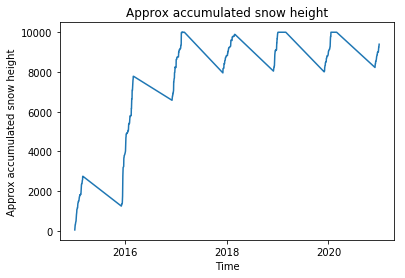

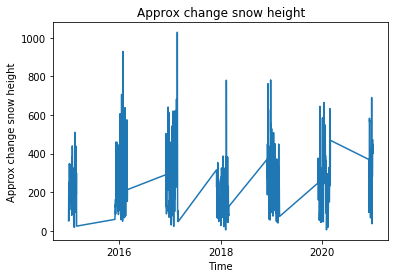

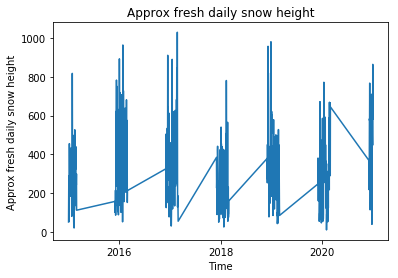

In [ ]:
print("plot percentiles")
percentile = 99.9
print("percentile: "+str(percentile))
for i_cube in tqdm(winter_cubelist):
    #qplt.plot(i_cube.collapsed(('latitude',"longitude"),iris.analysis.PERCENTILE,percent=[percentile]))
    aggregated = i_cube.aggregated_by(['season', 'season_year'],iris.analysis.MEAN)
    qplt.plot(i_cube.collapsed(('latitude',"longitude"),iris.analysis.PERCENTILE,percent=[percentile]))
    plt.show()

In [ ]:
print("plot percentiles")
percentile = 99
print("percentile: "+str(percentile))
for i_cube in tqdm(winter_cubelist):
    #qplt.plot(i_cube.collapsed(('latitude',"longitude"),iris.analysis.PERCENTILE,percent=[percentile]))
    aggregated = i_cube.aggregated_by(['season', 'season_year'],iris.analysis.MEAN)
    qplt.plot(i_cube.collapsed(('latitude',"longitude"),iris.analysis.PERCENTILE,percent=[percentile]))
    plt.show()
    

In [ ]:
print("plot percentiles")
percentile = 95
print("percentile: "+str(percentile))
for i_cube in tqdm(winter_cubelist):
    #qplt.plot(i_cube.collapsed(('latitude',"longitude"),iris.analysis.PERCENTILE,percent=[percentile]))
    aggregated = i_cube.aggregated_by(['season', 'season_year'],iris.analysis.MEAN)
    qplt.plot(i_cube.collapsed(('latitude',"longitude"),iris.analysis.PERCENTILE,percent=[percentile]))
    plt.show()

In [ ]:
print("Plot mean")    
# loop to plot country limited data graphs
for i_cube in tqdm(winter_cubelist):
    #qplt.plot(i_cube.collapsed(('latitude',"longitude"),iris.analysis.MEAN))
    aggregated = i_cube.aggregated_by(['season', 'season_year'],iris.analysis.MEAN)
    collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN)
    quadratic_fit(collapsed)
    plt.show()

